<a href="https://colab.research.google.com/github/Paresh-pk/Deploying-Quantized-Neural-Networks-for-Real-Time-Driver-Emotion-and-Seatbelt-Monitoring/blob/main/Deploying_Quantized_Neural_Networks_for_Real_Time_Driver_Emotion_and_Seatbelt_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install onnx onnxruntime tf2onnx


INFO: pip is looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.9.23
    Uninstalling flatbuffers-25.9.23:
      Successfully uninstalled flatbuffers-25.9.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires flatbuffers>=24.3.25, but you have flatbuffers 2.0.7 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import cv2 # OpenCV for face detection

# For ONNX conversion
import onnx
import onnxruntime as ort
import tf2onnx

In [4]:
# Load the dataset
data = pd.read_csv('fer2013.csv')

# Define emotion mapping
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Preprocess the data
pixels = data['pixels'].tolist()
faces = []
emotions_list = [] # Create a new list to store valid emotions
for i, pixel_sequence in enumerate(pixels):
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    if len(face) == 48 * 48: # Check if the number of pixels is correct
        face = np.asarray(face).reshape(48, 48)
        faces.append(face.astype('float32'))
        emotions_list.append(data['emotion'][i]) # Append the corresponding emotion
    else:
        print(f"Skipping row {i} due to incorrect pixel count: {len(face)}")


faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) # Add channel dimension for CNN

emotions = to_categorical(emotions_list, num_classes=len(emotion_labels)) # Use the new emotions_list

# Normalize image data
faces /= 255.0

# Split the data
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Skipping row 498 due to incorrect pixel count: 1043
Training set shape: (358, 48, 48, 1)
Validation set shape: (40, 48, 48, 1)
Test set shape: (100, 48, 48, 1)


 Face Detection and Emotion Model 🧠

We'll use a pre-trained Haar Cascade classifier from OpenCV for face detection (a simple and light alternative) and build a small CNN for emotion classification.

In [5]:
# Download the Haar Cascade file for frontal face detection
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2025-10-08 07:21:50--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2025-10-08 07:21:50 (31.1 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



Build the Emotion Classifier: Here is a simple but effective CNN architecture.

In [6]:
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(emotion_labels), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,495 (2.79 MB)

 Trainable params: 730,599 (2.79 MB)

 Non-trainable params: 896 (3.50 KB)

Train the Model: Train the classifier on the FER2013 data.

In [7]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=30, # Increase epochs for better accuracy if needed
                    validation_data=(X_val, y_val),
                    verbose=1)

# Save the trained model
model.save('emotion_classifier.h5')

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.1141 - loss: 3.2913 - val_accuracy: 0.1000 - val_loss: 1.9708
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 978ms/step - accuracy: 0.1917 - loss: 2.6046 - val_accuracy: 0.1000 - val_loss: 2.0713
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2467 - loss: 2.2420 - val_accuracy: 0.1000 - val_loss: 2.1539
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3008 - loss: 2.1988 - val_accuracy: 0.1000 - val_loss: 2.2433
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3414 - loss: 1.9223 - val_accuracy: 0.1250 - val_loss: 2.3300
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3878 - loss: 1.8163 - val_accuracy: 0.1250 - val_loss: 2.4836
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 950ms/step - accuracy: 0.4744 - loss: 1.4447 - val_accuracy: 0.1750 - val_loss: 2.6660
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4819 - loss: 1.4296 - val_accuracy: 0.1250 - val_loss: 2.7596
Epoch 9/

Evaluate the Model 📊

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Top-1 Accuracy on Test Set: {test_acc*100:.2f}%")

Top-1 Accuracy on Test Set: 18.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step


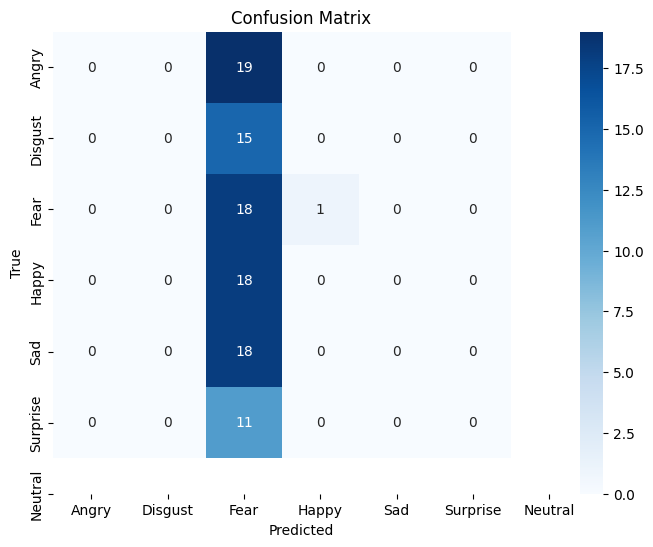

In [9]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Export to TFLite (with INT8 Quantization)

In [10]:
# TFLite conversion with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Create a representative dataset for calibration
def representative_dataset_gen():
    for i in range(100): # Use 100 samples from the training set
        yield [X_train[i:i+1]]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

# Save the quantized TFLite model
with open('emotion_classifier_int8.tflite', 'wb') as f:
    f.write(tflite_model_quant)

print("INT8 Quantized TFLite model saved as 'emotion_classifier_int8.tflite'")

Saved artifact at '/tmp/tmp8qpsnvah'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132406837560144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837560912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837562832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837563024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837561680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837562256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837559760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837562064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837561872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837564176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132406837563984:

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


INT8 Quantized TFLite model saved as 'emotion_classifier_int8.tflite'


Report Performance Metrics

In [20]:
keras_size = os.path.getsize('emotion_classifier.h5') / (1024 * 1024)
tflite_quant_size = os.path.getsize('emotion_classifier_int8.tflite') / (1024 * 1024)


print(f"Keras Model Size: {keras_size:.2f} MB")
print(f"TFLite INT8 Model Size: {tflite_quant_size:.2f} MB")


Keras Model Size: 8.48 MB
TFLite INT8 Model Size: 0.72 MB


In [21]:
import tensorflow as tf
import numpy as np
import time

# --- 1. Load the TFLite model and allocate tensors ---
interpreter = tf.lite.Interpreter(model_path="emotion_classifier_int8.tflite")
interpreter.allocate_tensors()

# --- 2. Get input and output tensor details ---
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input Details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
# Note the quantization parameters (scale, zero_point)
print("quantization:", input_details[0]['quantization'])

# --- 3. Prepare a dummy input tensor ---
# The model expects a batch of 1 image of shape 48x48 with 1 channel.
dummy_input_float32 = np.random.rand(1, 48, 48, 1).astype(np.float32)

# !!! CRUCIAL STEP: Quantize the float32 input to int8 !!!
# The model was converted to expect int8 inputs. We must convert our data.
# We get the quantization parameters from the input tensor details.
input_scale, input_zero_point = input_details[0]['quantization']

# The formula is: int_value = float_value / scale + zero_point
dummy_input_int8 = (dummy_input_float32 / input_scale + input_zero_point).astype(np.int8)

# --- 4. Run Inference and Measure Latency ---

# a) Warm-up run: The first inference is often slower, so we run it once
# to "warm up" the interpreter and don't include it in our measurement.
interpreter.set_tensor(input_details[0]['index'], dummy_input_int8)
interpreter.invoke()

# b) Timed run: Run the inference multiple times to get a stable average.
num_runs = 200
latencies = []

for _ in range(num_runs):
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], dummy_input_int8)
    interpreter.invoke()
    end_time = time.time()
    latencies.append((end_time - start_time) * 1000) # Convert to milliseconds

# c) Calculate and print the average latency
avg_latency_ms = np.mean(latencies)
print(f"\nAverage Latency per Frame (TFLite INT8 on CPU): {avg_latency_ms:.4f} ms")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


== Input Details ==
shape: [ 1 48 48  1]
type: <class 'numpy.int8'>
quantization: (0.003921568859368563, -128)

Average Latency per Frame (TFLite INT8 on CPU): 4.7059 ms


(Bonus)Simple Seat-Belt ROI Heuristic 🚗

Here's a conceptual bonus: a tiny binary CNN to check for a seat belt in a specific region.

Heuristic: A seat belt is a dark, diagonal line across the driver's chest. We can define a Region of Interest (ROI) from the top-left shoulder area downwards.

In [22]:
def create_dummy_data(size=64, num_samples=100):
    belts = []
    no_belts = []
    for _ in range(num_samples):
        # No belt (just noise)
        no_belt_img = np.random.randint(0, 50, (size, size), dtype=np.uint8)
        no_belts.append(no_belt_img)
        # Belt (noise + a diagonal line)
        belt_img = np.random.randint(0, 50, (size, size), dtype=np.uint8)
        cv2.line(belt_img, (5, 5), (size-10, size-10), (200), thickness=5)
        belts.append(belt_img)
    return np.array(belts), np.array(no_belts)

belt_imgs, no_belt_imgs = create_dummy_data()
X_seatbelt = np.concatenate([belt_imgs, no_belt_imgs])
X_seatbelt = X_seatbelt.reshape(-1, 64, 64, 1) / 255.0
y_seatbelt = np.array([1]*100 + [0]*100) # 1 for belt, 0 for no belt

X_train_sb, X_test_sb, y_train_sb, y_test_sb = train_test_split(X_seatbelt, y_seatbelt, test_size=0.2)

In [23]:
seatbelt_model = Sequential([
    Conv2D(8, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1, activation='sigmoid') # Binary classification
])

seatbelt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
seatbelt_model.fit(X_train_sb, y_train_sb, epochs=10, validation_data=(X_test_sb, y_test_sb), verbose=0)
print("Tiny seat-belt CNN trained.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tiny seat-belt CNN trained.
